In [25]:
from copy import deepcopy
import hubbard as hbb
import numpy as np
import scipy.sparse as sp
from qiskit import AncillaRegister, ClassicalRegister, QuantumCircuit
import qmatchatea as qtea
from qmatchatea.py_emulator import QcMps
from qmatchatea.preprocessing import _preprocess_qk

from hubbard.hamiltonian_terms import hopping_hamiltonian
import os

import matplotlib.pyplot as plt

shape = (4, 2)

In [50]:
def simple_visualizer(shape, state):
    state_str = []
    current_str = "│"
    vertical = " "*2+"│     "*shape[0]
    top = "┌─┴─┐ "*shape[0]
    bottom = "└─┬─┘ "*shape[0]
    for jj in range(shape[1]):
        state_str.append(bottom + "\n")
        for ii in range(shape[0]):
            if ii>0:
                current_str += "┤"
            idx = 2*(ii+ jj*shape[0])
            current_str += state[idx]+","+state[idx+1]+"├─"
        state_str.append(current_str[:-1]+"\n")
        state_str.append(top + "\n")
        if jj < shape[1]-1:
            state_str.append(vertical+"\n")
        current_str = "│"
    
    return "".join(state_str[::-1])

In [27]:
num_up = np.prod(shape)//4
num_down = np.prod(shape)//4
max_bond_dim = 10
conv_params = qtea.QCConvergenceParameters(max_bond_dimension=max_bond_dim, singval_mode='C')
all_states = hbb.all_possible_matter_states(shape, num_up, num_down)
print(f"There will be a total of {all_states.shape[0]} states")

# Hamiltonian of the symmetry sector
#symmetric_hamiltonian = np.zeros([all_states.shape[0]]*2, dtype=complex)
symmetric_hamiltonian = sp.lil_matrix(tuple([all_states.shape[0]]*2), dtype=complex)

# Vertexes definition
vertexes = [(ii, jj) for jj in range(shape[1]) for ii in range(shape[0])]
sites = [f"q({ii}, {jj})" for jj in range(shape[1]) for ii in range(shape[0])]
site_ordering = []
idx = 0
for ii, jj in vertexes:
    if (ii+jj)%2==0:
        site_ordering += [idx, idx+1]
    else:
        site_ordering += [idx+1, idx]
    idx += 2
# Plaquettes definition
plaquettes = [(ii, jj) for jj in range(shape[1]-1) for ii in range(shape[0]-1) ]
# Number of link qubits
num_links = shape[0]*(shape[1]-1) + shape[1]*(shape[0]-1)
num_qubs = 2*len(vertexes) + num_links + 1
qancilla = AncillaRegister(1, 'a0')
cancillas = [ClassicalRegister(1, f'ca{ii}') for ii in range(len(plaquettes)+len(vertexes)+1)]


# ============= Initialize Hubbard circuit =============
regs, qc = hbb.hubbard_circuit(shape, qancilla, cancillas )

if False:
    for ii, vv in enumerate(vertexes):
        qc = hbb.apply_vertex_parity_stabilizer(qc, regs, qancilla, cancillas[len(plaquettes)+ii], vv)
    for ii, pp in enumerate(plaquettes):
        qc = hbb.apply_plaquette_stabilizers(qc, regs, qancilla[0], cancillas[ii], pp )

    lin_qc = _preprocess_qk(qc)

    # Generate all the correct MPS states that respect
    # all the stabilizer checks
    mps_states = []
    for state in all_states:
        temp_qc = QuantumCircuit(*qc.qregs, *qc.cregs)
        temp_state = QcMps(num_qubs, conv_params)
        for idx, qub_state in enumerate(state):
            if qub_state == 1:
                site = sites[ idx//2 ]
                specie = "u" if idx%2 == 0 else "d"
                temp_qc.x( regs[site][specie] )
        
        temp_state.run_from_qk(temp_qc)
        temp_state.run_from_qk(lin_qc)
        mps_states.append(temp_state)

There will be a total of 784 states


In [28]:
save_dir = f"data/exact/{shape[0]}x{shape[1]}"
eigenvalues = np.loadtxt(os.path.join(save_dir, "eigenvalues.txt"))
eigenvectors = np.loadtxt(os.path.join(save_dir, "eigenvectors.txt"), dtype=complex)

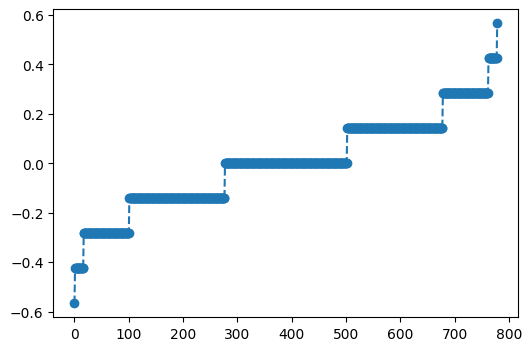

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(eigenvalues[:], 'o--')

plt.show()

In [32]:
all_state_strings = ["".join(list(state)) for state in all_states.astype(str) ]

In [56]:
def get_eigenvector_dict(idx, eigenvectors, str_states):
    eigv_dict = {}
    for jdx, coeff in enumerate(eigenvectors[:, idx]):
        if np.isclose(np.abs(coeff), 0):
            continue
        else:
            eigv_dict[str_states[jdx]] = coeff
    
    return eigv_dict

def get_eigenvector_str(idx, eigenvectors, str_states):
    eigv_str = ""
    for jdx, coeff in enumerate(eigenvectors[:, idx]):
        if np.isclose(np.abs(coeff), 0):
            continue
        elif np.isclose(np.imag(coeff), 0):
            coeff = np.real(coeff)
            eigv_str += "%.3f"%(coeff)
        elif np.isclose(np.real(coeff), 0):
            coeff = np.imag(coeff)
            eigv_str += "%.3f j"%(coeff)
        else:
            eigv_str += "(%.3f+ %.3f j)"%(np.real(coeff), np.imag(coeff))
        
        eigv_str += f"|{str_states[jdx]}> + "
    
    
    return eigv_str[:-3]

In [36]:
get_eigenvector_str(0, eigenvectors, all_state_strings)

'(-0.024+ -0.123 j)|0000000011000011> + (0.087+ -0.017 j)|0000000011000110> + (-0.087+ 0.017 j)|0000000011001001> + (0.012+ 0.061 j)|0000000011001100> + (0.087+ -0.017 j)|0000000111000010> + (-0.012+ -0.061 j)|0000000111001000> + (0.087+ -0.017 j)|0000001011000001> + (-0.012+ -0.061 j)|0000001011000100> + (0.012+ 0.061 j)|0000001111000000> + (-0.024+ -0.123 j)|0001000010000011> + (0.087+ -0.017 j)|0001000010000110> + (-0.087+ 0.017 j)|0001000010001001> + (-0.012+ -0.061 j)|0001000010001100> + (-0.087+ 0.017 j)|0001000110000010> + (0.012+ 0.061 j)|0001000110001000> + (0.087+ -0.017 j)|0001001010000001> + (-0.012+ -0.061 j)|0001001010000100> + (0.012+ 0.061 j)|0001001110000000> + (0.024+ 0.123 j)|0010000001000011> + (0.087+ -0.017 j)|0010000001000110> + (-0.087+ 0.017 j)|0010000001001001> + (-0.012+ -0.061 j)|0010000001001100> + (0.087+ -0.017 j)|0010000101000010> + (-0.012+ -0.061 j)|0010000101001000> + (-0.087+ 0.017 j)|0010001001000001> + (0.012+ 0.061 j)|0010001001000100> + (0.012+ 0

In [57]:
eigv_dict = get_eigenvector_dict(0, eigenvectors, all_state_strings)

for key, val in eigv_dict.items():   
    print(val)
    print( simple_visualizer(shape, key) )
    print("")

(-0.023554433358057646-0.12276069676073366j)
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│1,1├─┤0,0├─┤0,0├─┤1,1├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘ 
  │     │     │     │     
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│0,0├─┤0,0├─┤0,0├─┤0,0├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘ 


(0.08680492114270039-0.01665549955448938j)
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│1,1├─┤0,0├─┤0,1├─┤1,0├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘ 
  │     │     │     │     
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│0,0├─┤0,0├─┤0,0├─┤0,0├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘ 


(-0.08680492114270015+0.016655499554489295j)
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│1,1├─┤0,0├─┤1,0├─┤0,1├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘ 
  │     │     │     │     
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│0,0├─┤0,0├─┤0,0├─┤0,0├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘ 


(0.011777216679028746+0.06138034838036664j)
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│1,1├─┤0,0├─┤1,1├─┤0,0├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘ 
  │     │     │     │     
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│0,0├─┤0,0├─┤0,0├─┤0,0├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘ 


(0.08680492114270034-0.01665549955448937j)
┌─┴─┐ ┌─┴─┐ ┌─┴─┐ ┌─┴─┐ 
│1,1├─┤0,0├─┤0,0├─┤1,0├
└─┬─┘ └─┬─┘ └─┬─┘ └─┬─┘

In [41]:
all_state_strings[0]

'0000000000001111'